# Initialize
pwy_summary

In [99]:
from setup import (load_models,
                   convert_arg_to_list)
import pandas as pd 
from flux_ratio_analysis import (get_p_o_df, get_full_df)
from pathway_summary import (get_SG_pwy_df, get_pwy_rxn_df)
from growth_summary import (get_Biomass_df, get_desired_cycle, get_end_BM)
from pathway_summary import (get_rct_pathway_df,get_gene_pathway_df, 
                             get_gene_count_df, get_single_pathway_df)
from flux_snapshot import FluxCompare
from collections import Counter
import seaborn as sns
import ast

load_model_kwargs = { 
                'gal_scale': 3,
                'ac_scale': 10,
                'w': True
}

E0, S0, all_components = load_models(Egal_reuptake=False, **load_model_kwargs)

n_combos = 50
gene_combos = pd.read_csv('./Data/GeneCombos.csv',header=None)[0][:n_combos]
gene_combos = list(ast.literal_eval(ele) for ele in gene_combos) # list format
DG_list = list('.'.join(ele) for ele in gene_combos) # gene1.gene2 format


alpha_table = pd.read_csv("./Data/checkerboard_alpha_table.csv", index_col=0)
if len(alpha_table.columns) == 3:
    alpha_table.columns = ['E0', 'S0.ac', 'S0.glc']
else:
    alpha_table.lv_pairs = alpha_table.lv_pairs.apply(ast.literal_eval)
 
if 'Normal' in DG_list:
    DG_list.remove('Normal')
  
alpha_table = pd.read_csv("./Data/alpha_table_m1.csv", index_col=0) 
# Biomass summaries
Biomass_df = get_Biomass_df(['./Data/BM_SG_m1.csv', './Data/BM_DG_m1.csv'])
gr_df = pd.read_csv('./Data/gr_DG_m1_normalized.csv', index_col=0)

desired_cycle = get_desired_cycle(Biomass_df)
end_BM = get_end_BM(Biomass_df)

# pathway summary
rct_pathway_df = get_rct_pathway_df()
gene_pathway_df = get_gene_pathway_df(E0,alpha_table=alpha_table)

gene_count_df=get_gene_count_df(gene_pathway_df)
single_pathway_df = get_single_pathway_df(gene_pathway_df)
pwy_rxn_df = get_pwy_rxn_df(model=E0, E0=E0, S0=S0, alpha_table=alpha_table, DG_list=DG_list)

# calssification of drug combination effect
gr_DG = pd.read_csv('./Data/gr_DG_m1_normalized.csv', index_col=0)
p_o_full = get_p_o_df(E0, S0, gr_DG)



KeyboardInterrupt: 

In [ ]:
# flux extraction
file_list = ['./Data/flanalysis_BM_SG_m1.json', './Data/flanalysis_BM_DG_m1.json']
FC_kwargs = {
            # 'desired_cycle':desired_cycle.loc[['folP.folA_5.4']],
            'desired_cycle':desired_cycle,
            # 'file_list':j, 
            'file_list':file_list, 
            'E0': E0,
            'S0': S0,
            'alpha_table': alpha_table,
            'culture_options':['monoculture','coculture'], 
            'item_options':'flux'}

FC = FluxCompare(**FC_kwargs)
FC.retrive_specific_culture()
# FC.flux_dict = flux_dict
flux_compare_df = FC.get_flux_compare_df()

# merge to form complete df for analysis
additional_df_list = end_BM, pwy_rxn_df, flux_compare_df
flux_analysis_full = get_full_df(desired_cycle=desired_cycle, p_o_full=p_o_full,
                                 additional_df_list=additional_df_list)

In [ ]:
flux_analysis_full.to_csv('./Data/flux_analysis_m1.csv')

## carbon allocation 

In [ ]:
from importlib import reload
import flux_ratio_analysis

In [ ]:
def convert_po_col(col, additive_threshold=0.05):
    diff_bins = [-10,-1*additive_threshold,1*additive_threshold,10] 
    return pd.cut(col, bins=diff_bins, labels=['Antagonistic', 'Additive', 'Synergistic'])


In [605]:
flux_analysis_full = pd.read_csv('./Data/flux_analysis_m1.csv', index_col=0)
co_E = flux_analysis_full.query('Species=="E0"')
reload(flux_ratio_analysis)
from flux_ratio_analysis import get_carbon_allocation_summary

carbon_allocation_E = pd.concat(co_E.apply(lambda x: 
                                           get_carbon_allocation_summary(x, E0, all_components,format=False), axis=1)
                                            .tolist())
carbon_allocation_rxns = get_carbon_allocation_summary(co_E.iloc[0], E0, all_components).index # carbon allocation fluxes

carbon_allocation_E_wide = carbon_allocation_E.reset_index().pivot(index='Gene_inhibition',columns='reaction',values=['total_carbon', 'percent'])
# carbon_allocation_E_pivot = carbon_allocation_E.pivot(index='Gene_inhibition',columns='reaction',values=['total_carbon', 'percent'])
carbon_allocation_E_wide.columns = ['_'.join([col[0], col[1]]) for col in carbon_allocation_E_wide.columns]
carbon_allocation_E_wide = p_o_full.query('Species=="E0"').merge(carbon_allocation_E_wide,left_index=True, right_index=True, how='outer')
carbon_allocation_E_wide = carbon_allocation_E_wide.merge(flux_analysis_full.query('Species=="E0"')[['XG']], left_index=True, right_index=True) # only E0
carbon_allocation_E_wide['Drug_comb_effect_coc'] = convert_po_col(gr_df['po_diff_E0_coculture'])
carbon_allocation_E_wide['Drug_comb_effect_Emono'] = convert_po_col(gr_df['po_diff_E0_monoculture'])
carbon_allocation_E_wide['Drug_comb_effect_Smono'] = convert_po_col(gr_df['po_diff_S0_monoculture'])

if 'BM_consortia_frac_binned' not in carbon_allocation_E_wide.columns:
    carbon_allocation_E_wide = carbon_allocation_E_wide.merge(end_BM.query('Species=="E0"').BM_consortia_frac_binned, left_index=True, right_index=True)
carbon_allocation_E_wide = carbon_allocation_E_wide.reset_index('Species', drop=True)
# carbon_allocation_E_wide.to_csv('./Data/carbon_allocation.csv')
# # pairwise scatter plot for reach carbon terminal flux
# for x_col, y_col in itertools.combinations(carbon_allocation_rxns, 2):
#     carbon_allocation_E_long.plot.scatter('_'.join([prefix, x_col]), '_'.join([prefix, y_col]),c=color_list)


In [ ]:
import numpy as np

prefix='total_carbon'
prefix='percent'
x_col = 'EX_bulk_ac_e'
y_col = 'EX_lcts_e'
y_col = 'EX_lcts_e'
y_col = 'BIOMASS_iRR1083_metals'

# y_col = 'Waste'
# y_col = 'EX_co2_e'
def scatter_xycol(df, x_col, y_col, prefix='percent', XG=None):
    colors = {'Synergistic': 'red', 'Additive': 'purple', 'Antagonistic': 'blue', np.nan:'black'}
    # df.plot.scatter('total_carbon_EX_bulk_ac_e', 'total_carbon_Waste',c=color_list)
    if XG is not None:
        XG=convert_arg_to_list(XG)
        df = df.query('XG in @XG')
    color_list = [colors[group] for group in df['Drug_comb_effect']]
    # df.plot.scatter('_'.join([prefix, x_col]), '_'.join([prefix, y_col])
    #                 ,c=color_list, title=prefix + ' ' +' vs '.join([y_col,x_col]))
    sns.jointplot(data=df, x='_'.join([prefix, x_col]), y='_'.join([prefix, y_col]), hue='Drug_comb_effect', kind='kde')

# scatter_xycol(carbon_allocation_E_wide, x_col, y_col, XG='SG')

In [205]:
gr_po_mono = gr_df[['po_diff_E0_monoculture', 'po_diff_S0_monoculture']]

condition = (gr_po_mono.iloc[:,0] > 0.05) & (gr_po_mono.iloc[:,1] < -0.05)
sa_indexes = list(condition[condition].index)
condition_2 = (gr_po_mono.iloc[:,0] < -0.05) & (gr_po_mono.iloc[:,1] > 0.05)
as_indexes = condition_2[condition_2].index
sa_indexes.extend(as_indexes)
# false_indexes = [ele for ele in gr_po_mono.index if ele not in true_indexes]

In [561]:
def convert_po_col(col, additive_threshold=0.05):
    diff_bins = [-10,-1*additive_threshold,1*additive_threshold,10] 
    return pd.cut(col, bins=diff_bins, labels=['Antagonistic', 'Additive', 'Synergistic'])
    
def get_disagree_response():
    mono_response = pd.concat([convert_po_col(gr_df['po_diff_E0_monoculture']), convert_po_col(gr_df['po_diff_S0_monoculture'])], axis=1)
    response_df = gr_df.filter(regex='po_diff(?!.*rescaled)').apply(lambda x: convert_po_col(x, additive_threshold=.02), axis=0)
    finer_disagree_Smc = response_df[response_df['po_diff_E0_coculture'] != response_df['po_diff_S0_monoculture']]
    disagreement_response = list(finer_disagree_Smc.index)
    disagreement_response.remove('Normal')
    return disagreement_response
disagreement_response = get_disagree_response()
# stable_species_frac = end_BM.query('Species=="E0"').reset_index('Species', drop=True)['BM_consortia_frac']
# 

# ridge plots for percentage change compared to SG

In [607]:
gr_df = pd.read_csv('./Data/gr_DG_m1.csv', index_col=0)
fs_df = carbon_allocation_E_wide.merge(gr_df[['First_gene', 'Second_gene']], left_index=True, right_index=True)

fs_df = (fs_df.merge(carbon_allocation_E_wide, left_on='First_gene', right_index=True, suffixes=['','_First']) # add corresponding Frist and Second flux data
        .merge(carbon_allocation_E_wide, left_on='Second_gene', right_index=True, suffixes=['','_Second']))


In [611]:
def get_percent_cols(df, col_suffix=None, col_prefix='percent'):
    df = df.filter(regex=col_prefix)
    if not col_suffix:
        return df
    df = df.filter(like=col_suffix) 
    df.columns = df.columns.str.replace(col_suffix,'')
    return df

def get_sub_fs_change(fs_df, col_suffix='_First', col_prefix='percent'):
    fs = get_percent_cols(fs_df, col_suffix, col_prefix=col_prefix)
    fs_change = fs- get_percent_cols(carbon_allocation_E_wide.loc[fs.index], col_suffix=None, col_prefix=col_prefix) # change compared to single gene
    fs_change = fs_change.merge(carbon_allocation_E_wide[['Drug_comb_effect']], left_index=True, right_index=True).dropna(axis=0, how='all')
    return fs_change

def get_fs_change():
    gr_df = pd.read_csv('./Data/gr_DG_m1.csv', index_col=0)
    fs_df = carbon_allocation_E_wide.merge(gr_df[['First_gene', 'Second_gene']], left_index=True, right_index=True)

    fs_df = (fs_df.merge(carbon_allocation_E_wide, left_on='First_gene', right_index=True, suffixes=['','_First']) # add corresponding Frist and Second flux data
            .merge(carbon_allocation_E_wide, left_on='Second_gene', right_index=True, suffixes=['','_Second']))
    fs_change = pd.concat([get_sub_fs_change(fs_df, '_First'), get_sub_fs_change(fs_df, '_Second')])
    fs_change = fs_change.sort_index()
    fs_change['Nth_gene'] = list(['First','Second']*50)

    return fs_change

def plot_kde(plot_df, reaction=None, labels=['Waste', 'CO2', 'Acetate', 'Biomass'], col_prefix='percent_', common_norm=False, ylim=None): 
    sns.set_style('whitegrid', {'legend.frameon':True})
    color_dict = {
    'Waste': 'purple',
    'EX_co2_e': 'green',
    'EX_bulk_ac_e': 'blue',
    'BIOMASS_Ec_iML1515_core_75p37M': 'red',
    }
    color_dict = {col_prefix+k: v for k, v in color_dict.items()}

    plot_df.rename({'flux':'Portion change in carbon allocation'}, inplace=True, axis=1)
    print(plot_df.columns)
    g = sns.FacetGrid(plot_df, col="Drug_comb_effect")
    g.map_dataframe(sns.kdeplot, x="Portion change in carbon allocation", hue="reaction", fill=True, common_norm=common_norm, alpha=0.15, palette=color_dict)
    # g.map_dataframe(sns.kdeplot, x="flux", hue="reaction", fill=True, common_norm=True, alpha=0.2, palette=color_dict)
    if ylim:
        g.set(ylim=ylim)
    title = reaction if reaction else 'Change in Carbon Allocation Portion Profile (Double Gene minus Single Gene)'
    g.fig.suptitle(title, fontsize=8)
    # plt.legend(title='', loc='upper left', labels = color_dict.keys())
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    if not labels:
        labels = color_dict.keys
    col_prefix = 'percentage of \n total carbon uptaken' if col_prefix == 'percent_' else 'total carbon'
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0., title=f'Change in {col_prefix}', loc='upper left', labels = labels)



In [619]:
fs_change = get_fs_change()
fs_plot = fs_change.drop(['percent_EX_lcts_e', 'percent_EX_for_e', 'percent_EX_gal_e', 'percent_EX_glyclt_e', 'percent_EX_met__L_e'], axis=1)
# fs_plot = fs_plot.set_index('Drug_comb_effect', append=True).melt()
fs_plot = pd.melt(fs_plot, id_vars=['Drug_comb_effect'], var_name='reaction', value_name='flux')

fs_change = fs_change.merge(carbon_allocation_E_wide.loc[:,'Drug_comb_effect_coc':], left_index=True, right_index=True)

exclusion_rxns = ['EX_lcts_e', 'EX_for_e', 'EX_gal_e', 'EX_glyclt_e', 'EX_met__L_e']


In [637]:
fs_change

,percent_BIOMASS_Ec_iML1515_core_75p37M,percent_EX_bulk_ac_e,percent_EX_co2_e,percent_EX_for_e,percent_EX_gal_e,percent_EX_glyclt_e,percent_EX_lcts_e,percent_EX_met__L_e,percent_Waste,Drug_comb_effect,Nth_gene,Drug_comb_effect_coc,Drug_comb_effect_Emono,Drug_comb_effect_Smono,BM_consortia_frac_binned
Gene_inhibition,,,,,,,,,,,,,,,
acnB.ackA,-0.236130,0.005772,-0.075382,NaN,NaN,NaN,0.0,0.004625,0.240406,Additive,First,Additive,Antagonistic,Additive,S
acnB.ackA,-0.167441,-0.073314,-0.102184,NaN,NaN,NaN,0.0,0.003279,0.277605,Additive,Second,Additive,Antagonistic,Additive,S
acnB.gltA,-0.167346,-0.193324,-0.074463,NaN,NaN,NaN,0.0,0.003277,0.435133,Additive,First,Additive,Synergistic,Additive,S
acnB.gltA,-0.354147,-0.233906,-0.119610,NaN,NaN,NaN,0.0,0.006936,0.717375,Additive,Second,Additive,Synergistic,Additive,S
acnB.purT,-0.236130,0.005772,-0.075382,NaN,NaN,NaN,0.0,0.004625,0.240406,Additive,First,Additive,Antagonistic,Additive,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
thrC.thrB,-0.179451,0.318316,0.080745,NaN,NaN,NaN,0.0,NaN,-0.219610,Synergistic,Second,Synergistic,Synergistic,Synergistic,slight E
tktA.gnd,-0.092531,0.020237,0.039787,NaN,NaN,NaN,0.0,0.001812,0.032507,Synergistic,First,Additive,Synergistic,Synergistic,E
tktA.gnd,-0.172923,0.026008,-0.149836,NaN,NaN,NaN,0.0,0.003387,0.303756,Synergistic,Second,Additive,Synergistic,Synergistic,E


# percentage change relative to single gene
antagonistic retain ability to cope with additional purturbation-by increase in % of waste

synergism - reduced flux through waste & # bimodal change in energy production response

In [565]:
invalid_coc = ['gltA','acnB','pgk','aceF','eno','yrbG','purT','ackA','gapA']
exclude_pairs = [ele for ele in gene_combos if any([gene in ele for gene in invalid_coc])]
exclude_pairs = ['.'.join(ele) for ele in exclude_pairs]
exclude_pairs

['dadX.eno',
 'dadX.acnB',
 'dapF.acnB',
 'dadX.gapA',
 'acnB.thrB',
 'acnB.gltA',
 'gltA.gltD',
 'acnB.purT',
 'acnB.ackA']

In [736]:
def customize_row_color(df, col, color, col_elements=None):
    if 'comb' in col:
        lut = dict(zip(['Antagonistic', 'Additive', 'Synergistic'], ['#90fda9', '#ffff84', '#fed0fc']))
    else:
        elements = df[col].unique() if not col_elements else col_elements
        print(elements)
        lut = dict(zip(elements, color))
    print(lut)
    row_colors = df[col].map(lut)
    return row_colors

def generate_row_colors(fs_sub_change, color, colnames=None):
    row_colors_response = customize_row_color(fs_sub_change, 'Drug_comb_effect_coc', 'rbg')
    row_colors_Smono = customize_row_color(fs_sub_change, 'Drug_comb_effect_Smono', 'rbg')
    row_colors_Emono = customize_row_color(fs_sub_change, 'Drug_comb_effect_Emono', 'rbg')
    # row_colors_BM_frac = customize_row_color(fs_sub_change, 'BM_consortia_frac_binned',col_elements=['E', 'slight E','S'], color=['#ff05e8', '#e03fd8', '#f075e6'])
    # row_colors_BM_frac = customize_row_color(fs_sub_change, 'BM_consortia_frac_binned',col_elements=['E', 'slight E','S'], color=['#c14a09', '#D46C4E', '#F9AD6A'])
    row_colors_BM_frac = customize_row_color(fs_sub_change, 'BM_consortia_frac_binned',col_elements=['E', 'slight E','S'], color=color)
    row_colors = pd.concat([row_colors_Smono,row_colors_response,row_colors_Emono, row_colors_BM_frac],axis=1)
    if colnames is None:
        row_colors.columns = ['DCE Smono', 'DCE Eco', 'DCE Emono', 'Rel. Abund']
    return row_colors

In [573]:
rxn_cols = list(fs_plot.reaction.unique())
rxn_cols.append('Drug_comb_effect')
# fs_sub_change = carbon_allocation_E_wide[rxn_cols] # fs_sub_flux instead
fs_sub_change = fs_change[rxn_cols] # fs_sub_flux instead


NotImplementedError: Index._join_level on non-unique index is not implemented

In [743]:
p_cols = ['percent_BIOMASS_Ec_iML1515_core_75p37M', 'percent_EX_bulk_ac_e', 'percent_EX_co2_e', 'percent_Waste']
total_carobn_cols = [ele.replace('percent', 'plot_total_carbon') for ele in p_cols]  
 
fs_sub_change=  (fs_change
                 .set_index('Nth_gene', append=True)
                 .loc[:,p_cols].merge(carbon_allocation_E_wide.loc[:,'Drug_comb_effect_coc':], left_index=True, right_index=True)
 .dropna(axis=0, how='any'))

Normal_row = pd.DataFrame(0, columns = fs_sub_change.columns, index = ['Normal'])
Normal_row.loc[:,'Drug_comb_effect_coc':'BM_consortia_frac_binned']=None
Normal_row['Nth_gene'] = 'Normal'
Normal_row.index.name='Gene_inhibition'
Normal_row.set_index('Nth_gene', append=True, inplace=True)
Normal_row
fs_sub_change = pd.concat([fs_sub_change, Normal_row])


{'Antagonistic': '#90fda9', 'Additive': '#ffff84', 'Synergistic': '#fed0fc'}
{'Antagonistic': '#90fda9', 'Additive': '#ffff84', 'Synergistic': '#fed0fc'}
{'Antagonistic': '#90fda9', 'Additive': '#ffff84', 'Synergistic': '#fed0fc'}
['E', 'slight E', 'S']
{'E': '#4622fc', 'slight E': '#9d22fc', 'S': '#da52d5'}


Text(0.5, 167.91666666666686, 'Differential Carbon Allocation (Double - Single Drug Inhibition)')

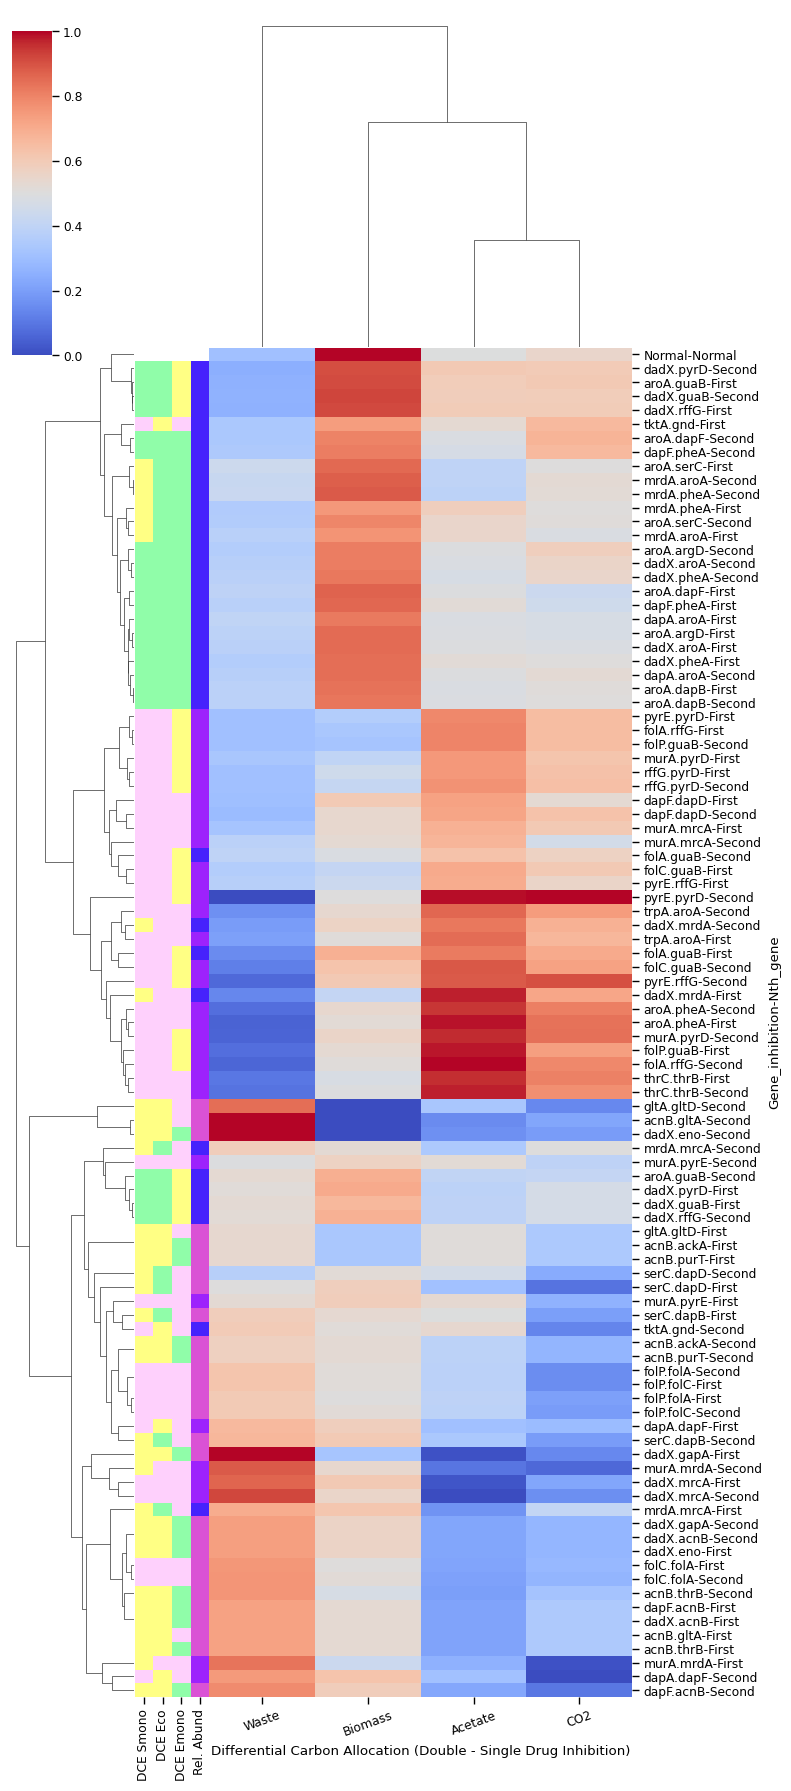

In [744]:
clustered = sns.clustermap(fs_sub_change.loc[:,p_cols] 
            , row_colors=generate_row_colors(fs_sub_change, color=[ '#4622fc','#9d22fc', '#da52d5'])
            , standard_scale=1
            , yticklabels=True
            , figsize=(8, 14)
            , cmap='coolwarm')
# clustered.ax_heatmap.set_xticklabels(['Biomass', 'Acetate', 'CO2', 'Waste'], rotation=20)
clustered.ax_heatmap.set_xticklabels(['Biomass', 'Acetate', 'CO2', 'Waste'], rotation=20)
clustered.ax_heatmap.set_xlabel(r'Differential Carbon Allocation (Double - Single Drug Inhibition)', weight='bold')


In [551]:
# fs_sub_change.pop('Drug_comb_effect')

# sns.clustermap(fs_sub_change.drop(['Drug_comb_effect','S_agreement'], axis=1).abs(), standard_scale=1, row_colors=[ row_colors_response, row_colors_agree],)
# sns.clustermap(fs_sub_change.loc[:,'percent_BIOMASS_Ec_iML1515_core_75p37M':'percent_Waste'].abs(), standard_scale=1, row_colors=row_colors,)
# sns.clustermap(fs_sub_change.loc[:,'percent_BIOMASS_Ec_iML1515_core_75p37M':'percent_Waste'], standard_scale=1, row_colors=row_colors,)
# sns.clustermap(fs_sub_change.loc[sub_disagreement_response,'percent_BIOMASS_Ec_iML1515_core_75p37M':'percent_Waste'], standard_scale=1, row_colors=row_colors,)
sns.clustermap(fs_sub_change.loc[:,'percent_BIOMASS_Ec_iML1515_core_75p37M':'percent_Waste']
               , row_colors=generate_row_colors(fs_sub_change))
# sns.clustermap(fs_sub_change.loc[:,'percent_BIOMASS_Ec_iML1515_core_75p37M':'percent_Waste'], row_colors=row_colors,)


{'Antagonistic': '#90fda9', 'Additive': '#ffff84', 'Synergistic': '#fed0fc'}


KeyError: 'Drug_comb_effect_coc'

In [376]:
# concat a samoella acetate flux
# use resultant portion 
fs_sub_change.loc[sub_disagreement_response,'percent_BIOMASS_Ec_iML1515_core_75p37M':'percent_Waste'].columns

Index(['percent_BIOMASS_Ec_iML1515_core_75p37M', 'percent_EX_bulk_ac_e',
       'percent_EX_co2_e', 'percent_Waste'],
      dtype='object')

In [395]:
disagreement_response

['mrdA.mrcA',
 'serC.dapD',
 'serC.dapB',
 'mrdA.aroA',
 'mrdA.pheA',
 'aroA.serC',
 'murA.mrdA',
 'serC.dapF',
 'dadX.mrdA']

In [403]:
carbon_allocation_E_wide.columns

Index(['Predicted_growth_rate', 'Observed_growth_rate', 'P_O',
       'Drug_comb_effect', 'PGR_bin', 'OGR_bin', 'gene_sort', 'Species',
       'Pathway_count', 'Pathway_list', 'Single_pathway',
       'total_carbon_BIOMASS_Ec_iML1515_core_75p37M',
       'total_carbon_EX_bulk_ac_e', 'total_carbon_EX_co2_e',
       'total_carbon_EX_for_e', 'total_carbon_EX_gal_e',
       'total_carbon_EX_glyclt_e', 'total_carbon_EX_lcts_e',
       'total_carbon_EX_met__L_e', 'total_carbon_Waste',
       'percent_BIOMASS_Ec_iML1515_core_75p37M', 'percent_EX_bulk_ac_e',
       'percent_EX_co2_e', 'percent_EX_for_e', 'percent_EX_gal_e',
       'percent_EX_glyclt_e', 'percent_EX_lcts_e', 'percent_EX_met__L_e',
       'percent_Waste', 'XG', 'S_agreement'],
      dtype='object')

In [586]:
# carbon_allocation_E_wide['S_agreement'] = carbon_allocation_E_wide.apply(lambda x: 'Disagree' if x.name in disagreement_response else 'Agree', axis=1)
if 'BM_consortia_frac_binned' not in carbon_allocation_E_wide.columns:
    carbon_allocation_E_wide = carbon_allocation_E_wide.merge(end_BM.query('Species=="E0"').BM_consortia_frac_binned, left_index=True, right_index=True)


In [407]:
carbon_allocation_E_wide.loc[sub_disagreement_response,p_cols]

,,percent_BIOMASS_Ec_iML1515_core_75p37M,percent_EX_bulk_ac_e,percent_EX_co2_e,percent_Waste
Gene_inhibition,Species,,,,
mrdA.mrcA,E0,-0.041557,-0.114561,-0.219685,-0.624197
serC.dapD,E0,-0.021590,-0.196667,-0.106400,-0.434475
serC.dapB,E0,-0.027242,-0.220449,-0.093231,-0.659077
mrdA.aroA,E0,-0.126033,-0.255558,-0.214194,-0.404215
mrdA.pheA,E0,-0.122168,-0.277026,-0.221645,-0.379160
aroA.serC,E0,-0.118910,-0.255154,-0.205060,-0.420876
murA.mrdA,E0,-0.009616,-0.057148,-0.043172,-0.878430
dadX.mrdA,E0,-0.001234,-0.541460,-0.297745,-0.159561


In [631]:
# carbon_allocation_E_wide.loc[sub_disagreement_response_wnormal,total_carobn_cols]
def assign_plot_total_E_wide(carbon_allocation_E_wide):
    carbon_allocation_E_wide['plot_total_carbon_Waste'] = np.log(carbon_allocation_E_wide['total_carbon_Waste'])
    carbon_allocation_E_wide.loc['Normal','plot_total_carbon_Waste']=-10

    # carbon_allocation_E_wide['plot_total_carbon_EX_bulk_ac_e'] = carbon_allocation_E_wide['total_carbon_EX_bulk_ac_e']/-2
    carbon_allocation_E_wide['plot_total_carbon_EX_bulk_ac_e'] = carbon_allocation_E_wide['total_carbon_EX_bulk_ac_e']/-1
    carbon_allocation_E_wide['plot_total_carbon_BIOMASS_Ec_iML1515_core_75p37M'] = carbon_allocation_E_wide['total_carbon_BIOMASS_Ec_iML1515_core_75p37M']*-1
    carbon_allocation_E_wide['plot_total_carbon_EX_co2_e'] = carbon_allocation_E_wide['total_carbon_EX_co2_e']*-1
    return carbon_allocation_E_wide

C:\Users\wongt\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


{'Antagonistic': '#90fda9', 'Additive': '#ffff84', 'Synergistic': '#fed0fc'}
{'Antagonistic': '#90fda9', 'Additive': '#ffff84', 'Synergistic': '#fed0fc'}
{'Antagonistic': '#90fda9', 'Additive': '#ffff84', 'Synergistic': '#fed0fc'}
['E', 'slight E', 'S']
{'E': '#c14a09', 'slight E': '#D46C4E', 'S': '#F9AD6A'}


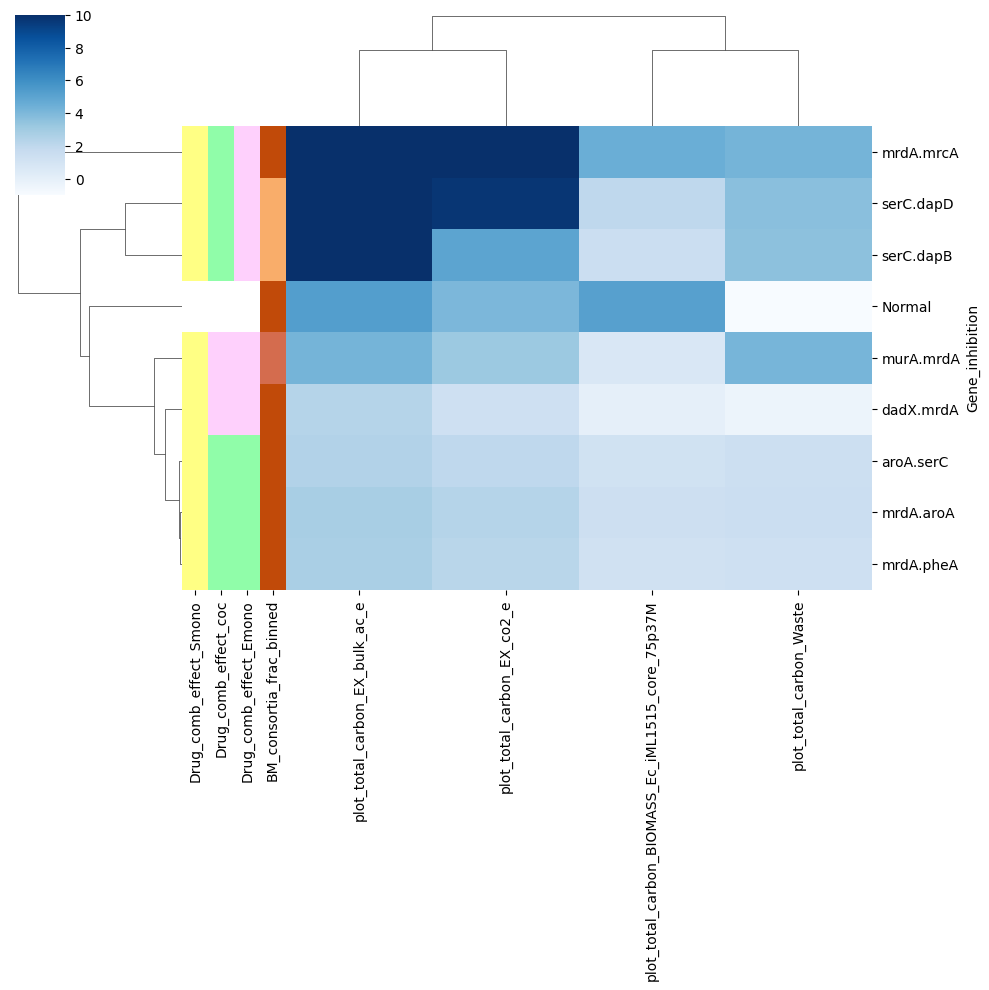

In [632]:
p_cols = ['percent_BIOMASS_Ec_iML1515_core_75p37M', 'percent_EX_bulk_ac_e', 'percent_EX_co2_e', 'percent_Waste']
total_carobn_cols = [ele.replace('percent', 'plot_total_carbon') for ele in p_cols]  
 
# cluster_carbon_allocation = carbon_allocation_E_wide.merge()
# sns.clustermap(carbon_allocation_E_wide.loc[sub_disagreement_response,p_cols].abs(), row_colors=generate_row_colors(carbon_allocation_E_wide),)
# sns.clustermap(carbon_allocation_E_wide.loc[sub_disagreement_response,total_carobn_cols].abs(), standard_scale=1,row_colors=generate_row_colors(carbon_allocation_E_wide),)
sub_disagreement_response_wnormal = sub_disagreement_response.copy()
sub_disagreement_response_wnormal.extend(['Normal'])

sns.clustermap(assign_plot_total_E_wide(
                    carbon_allocation_E_wide).loc[sub_disagreement_response_wnormal,total_carobn_cols], # flux magnitude
               row_colors=generate_row_colors(carbon_allocation_E_wide)
               , cmap='Blues'
               , vmin=-1
               , vmax=10)

Index(['Drug_comb_effect', 'reaction', 'Portion change in carbon allocation'], dtype='object')


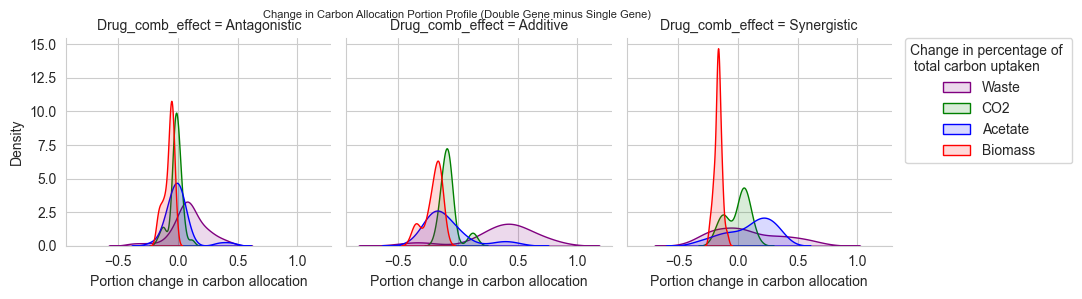

In [ ]:
plot_kde(fs_plot)


# scatter plot 

add vector field


In [ ]:
iris = sns.load_dataset("iris")
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [ ]:
fs_sub_change

,percent_BIOMASS_Ec_iML1515_core_75p37M,percent_EX_bulk_ac_e,percent_EX_co2_e,percent_Waste,Drug_comb_effect
Gene_inhibition,,,,,
Normal,-0.353438,-0.359781,-0.277095,0.000000,NaN
Normal,-0.353438,-0.359781,-0.277095,0.000000,NaN
aceF,-0.180379,-0.324747,-0.242866,-0.252007,NaN
aceF,-0.180379,-0.324747,-0.242866,-0.252007,NaN
ackA,-0.236276,-0.248855,-0.195428,-0.319441,NaN
...,...,...,...,...,...
trpA,-0.178841,-0.334001,-0.250347,-0.236812,NaN
trpA.aroA,-0.005850,-0.567910,-0.292958,-0.133282,Synergistic
trpA.aroA,-0.005850,-0.567910,-0.292958,-0.133282,Synergistic


In [ ]:
fs_sub_change =fs_change.drop(['percent_EX_lcts_e', 'percent_EX_for_e', 'percent_EX_gal_e', 'percent_EX_glyclt_e', 'percent_EX_met__L_e'], axis=1)


In [ ]:
fs_change

,percent_BIOMASS_Ec_iML1515_core_75p37M,percent_EX_bulk_ac_e,percent_EX_co2_e,percent_EX_for_e,percent_EX_gal_e,percent_EX_glyclt_e,percent_EX_lcts_e,percent_EX_met__L_e,percent_Waste,Drug_comb_effect
Gene_inhibition,,,,,,,,,,
acnB.ackA,-0.167441,-0.073314,-0.102184,NaN,NaN,NaN,0.0,0.003279,0.277605,Additive
acnB.ackA,-0.167441,-0.073314,-0.102184,NaN,NaN,NaN,0.0,0.003279,0.277605,Additive
acnB.ackA,-0.167441,-0.073314,-0.102184,NaN,NaN,NaN,0.0,0.003279,0.277605,Additive
acnB.ackA,-0.167441,-0.073314,-0.102184,NaN,NaN,NaN,0.0,0.003279,0.277605,Additive
acnB.ackA,-0.167441,-0.073314,-0.102184,NaN,NaN,NaN,0.0,0.003279,0.277605,Additive
...,...,...,...,...,...,...,...,...,...,...
trpA.aroA,-0.163922,0.242516,0.069722,NaN,NaN,NaN,0.0,0.003210,-0.148316,Synergistic
trpA.aroA,-0.163922,0.242516,0.069722,NaN,NaN,NaN,0.0,0.003210,-0.148316,Synergistic
trpA.aroA,-0.163922,0.242516,0.069722,NaN,NaN,NaN,0.0,0.003210,-0.148316,Synergistic


C:\Users\wongt\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
C:\Users\wongt\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
C:\Users\wongt\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)


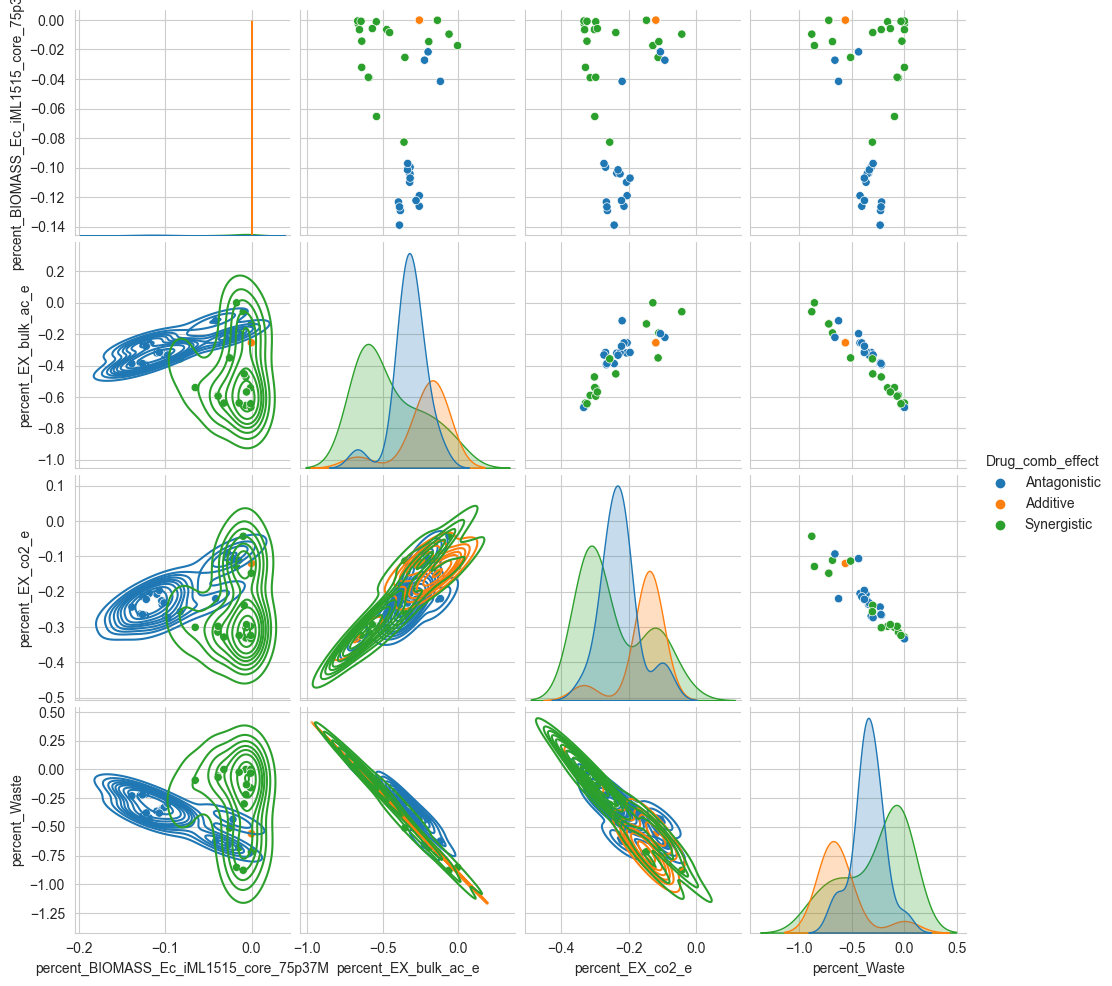

In [ ]:
# sns.PairGrid(iris)
fsp = sns.pairplot(fs_sub_change.iloc[::2], hue='Drug_comb_effect')
fsp.map_lower(sns.kdeplot)

Text(40.347222222222214, 0.5, 'Change in portion of carbon allocated to CO2 production (%)')

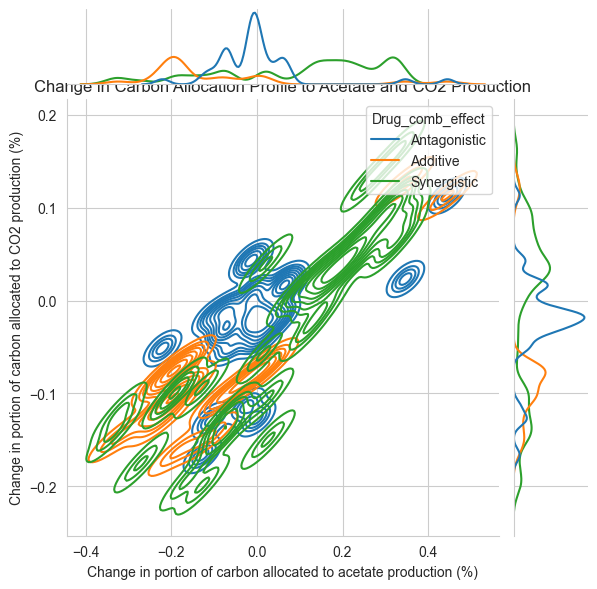

In [ ]:
fs_to_plot = fs_change.merge(carbon_allocation_E_wide[['Drug_comb_effect']], left_index=True, right_index=True, suffixes=['','w']).dropna(axis=0, how='all')

def scatter_xycol(df, x_col, y_col, prefix='percent', XG=None):
    colors = {'Synergistic': 'red', 'Additive': 'purple', 'Antagonistic': 'blue', np.nan:'black'}
    # df.plot.scatter('total_carbon_EX_bulk_ac_e', 'total_carbon_Waste',c=color_list)
    if XG is not None:
        XG=convert_arg_to_list(XG)
        df = df.query('XG in @XG')
    color_list = [colors[group] for group in df['Drug_comb_effect']]
    # df.plot.scatter('_'.join([prefix, x_col]), '_'.join([prefix, y_col])
    #                 ,c=color_list, title=prefix + ' ' +' vs '.join([y_col,x_col]))
    # sns.scatterplot(data=df, x='_'.join([prefix, x_col]), y='_'.join([prefix, y_col]), hue='Drug_comb_effect') 
    sns.jointplot(data=df, x='_'.join([prefix, x_col]), y='_'.join([prefix, y_col]), hue='Drug_comb_effect',kind='kde') 

y_col = 'EX_lcts_e'
y_col = 'BIOMASS_Ec_iML1515_core_75p37M'
y_col = 'Waste'
y_col = 'EX_co2_e'
prefix='percent'
x_col = 'EX_bulk_ac_e'
y_col = 'EX_lcts_e'
y_col = 'EX_lcts_e'
y_col = 'BIOMASS_Ec_iML1515_core_75p37M'
y_col = 'Waste'
y_col = 'EX_co2_e'
scatter_xycol(fs_to_plot, x_col, y_col)
plt.title('Change in Carbon Allocation Profile to Acetate and CO2 Production')
plt.xlabel('Change in portion of carbon allocated to acetate production (%)')
plt.ylabel('Change in portion of carbon allocated to CO2 production (%)')
# stable energy production pattern for antagonistic drug pairs

# metabolite allocation

In [ ]:
reload(flux_ratio_analysis)
from flux_ratio_analysis import get_metabolite_summary
# get_metabolite_summary(co_E.loc['folP'],'ac_c',model=E0, all_components=all_components)
 
ac_production_E = pd.concat(co_E.apply(lambda x: 
                                       get_metabolite_summary(x, 'atp_c',model=E0, all_components=all_components, concat=True)
                                       , axis=1)
                                       .tolist())
# ac_production_E.query('index=="ATPS4rpp"')
carbon_allocation_E_wide= ac_production_E.query('index=="BIOMASS_Ec_iML1515_core_75p37M"')
carbon_allocation_E_wide.merge(p_o_full.query("Species=='E0'")[['Drug_comb_effect']], left_on='Gene_inhibition', right_index=True)

# reduction in ratio compared to SG
# see if ratio changed between monocultue and coculture
    # -> indication of exclusion of methionine limiting effect

E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0
E0


# GI effect >  methionine limiting 

In [ ]:
# locate the gene inhibition that inhibits E.coli
met_cm = flux_compare_df.query('Species=="E0"')[['EX_met__L_e','culture']]
# S>E
s = Biomass_df.filter(regex='coc').iloc[-1,::2]-list(Biomass_df.filter(regex='coc').iloc[-1,1::2])
swap_ratio = s[s<0]
sr_gc = {k.split('_')[1] :v for k, v in swap_ratio.to_dict().items()}
met_cm.query("Gene_inhibition in @sr_gc.keys()")

# energy pathway already overinhibition in m1

In [ ]:
desired_items = ['Alternate Carbon Metabolism', 'Glycolysis/Gluconeogenesis', 'Pentose Phosphate Pathway', 'Citric Acid Cycle', 'Glycolysis/Gluconeogenesis', 'Pentose Phosphate Pathway']

expsingle = single_pathway_df.explode('Pathway_list').query('XG=="DG"').query('Pathway_list in @desired_items').index.unique()
expsingle

Index(['tktA.gnd', 'acnB.gltA', 'dadX.eno', 'gltA.gltD', 'acnB.ackA',
       'acnB.thrB', 'dadX.acnB', 'dapF.acnB', 'acnB.purT', 'dadX.gapA'],
      dtype='object', name='Gene_inhibition')

In [ ]:
gr_df = pd.read_csv('./Data/gr_DG_m3_normalized.csv', index_col=0)
# gr_df.loc[expsingle].query('po_diff_E0_coculture<0')
gr_df.loc[expsingle]

,E0_coculture,S0_coculture,Predicted_additive_effect_E0_coculture,Predicted_additive_effect_S0_coculture,E0_monoculture,S0_monoculture,Predicted_additive_effect_E0_monoculture,Predicted_additive_effect_S0_monoculture,First_gene,E0_coculture_First_gene,...,E0_monoculture_Second_gene,S0_monoculture_Second_gene,po_diff_E0_coculture,po_diff_S0_coculture,po_diff_E0_monoculture,po_diff_S0_monoculture,po_diff_E0_coculture_rescaled_by_predicted,po_diff_S0_coculture_rescaled_by_predicted,po_diff_E0_monoculture_rescaled_by_predicted,po_diff_S0_monoculture_rescaled_by_predicted
Gene_inhibition,,,,,,,,,,,,,,,,,,,,,
tktA.gnd,0.110435,0.095062,0.143112,0.142288,0.474888,0.240061,0.787576,2.814898,tktA,0.473897,...,1.000000,5.796411,0.032677,0.047227,0.312688,2.574837,0.228315,0.331886,0.397021,0.914714
acnB.gltA,0.378069,0.375296,0.462223,0.461486,0.994315,0.567865,0.994530,0.626933,acnB,0.503855,...,0.998578,0.768911,0.084154,0.086190,0.000215,0.059068,0.182059,0.186762,0.000217,0.094216
dadX.eno,0.000000,0.000000,0.000000,0.000000,0.577242,0.576124,0.435429,2.473946,dadX,0.303165,...,0.601041,4.246922,0.000000,0.000000,-0.141813,1.897823,0.000000,0.000000,-0.325678,0.767120
gltA.gltD,2.362263,2.519882,1.263583,1.258156,0.562087,0.768912,0.565969,4.457010,gltA,0.917372,...,0.566776,5.796524,-1.098680,-1.261726,0.003883,3.688098,-0.869489,-1.002830,0.006860,0.827481
acnB.ackA,0.000000,0.000000,0.000000,0.000000,0.870943,0.253301,0.870062,4.374052,acnB,0.503855,...,0.873603,5.364615,0.000000,0.000000,-0.000881,4.120752,0.000000,0.000000,-0.001012,0.942088
acnB.thrB,0.258932,0.256804,0.270239,0.267562,0.476470,0.487638,0.474539,0.487543,acnB,0.503855,...,0.476470,0.597954,0.011307,0.010758,-0.001931,-0.000095,0.041838,0.040206,-0.004070,-0.000194
dadX.acnB,0.150023,0.141999,0.152751,0.150125,0.724458,0.473821,0.721521,0.474965,dadX,0.303165,...,0.995947,0.815353,0.002729,0.008125,-0.002936,0.001144,0.017863,0.054121,-0.004070,0.002408
dapF.acnB,0.163551,0.156895,0.100718,0.099560,0.551514,0.474477,0.549278,3.334415,dapF,0.199895,...,0.995947,0.815353,-0.062833,-0.057335,-0.002235,2.859938,-0.623787,-0.575826,-0.004070,0.857700
acnB.purT,0.000000,0.000000,0.000000,0.000000,0.870943,0.253301,0.870062,4.374052,acnB,0.503855,...,0.873603,5.364615,0.000000,0.000000,-0.000881,4.120752,0.000000,0.000000,-0.001012,0.942088


In [ ]:
query_pwy = ['a']
expsingle.query

,XG,Pathway_count,Pathway_list,Single_pathway
Gene_inhibition,,,,
aroA.pheA,DG,1,"Tyrosine, Tryptophan, and Phenylalanine Metabo...",Single_pathway
dapA.dapF,DG,1,Threonine and Lysine Metabolism,Single_pathway
dapF.dapD,DG,1,Threonine and Lysine Metabolism,Single_pathway
folC.folA,DG,1,Cofactor and Prosthetic Group Biosynthesis,Single_pathway
folP.folA,DG,1,Cofactor and Prosthetic Group Biosynthesis,Single_pathway
...,...,...,...,...
aroA.serC,DG,4,"Tyrosine, Tryptophan, and Phenylalanine Metabo...",Multi_pathway
dadX.gapA,DG,4,Metabolite Repair,Multi_pathway
dadX.gapA,DG,4,Alanine and Aspartate Metabolism,Multi_pathway


In [ ]:
single_pathway_df.loc['s`erC'].Pathway_list

['Cofactor and Prosthetic Group Biosynthesis',
 'Threonine and Lysine Metabolism',
 'Glycine and Serine Metabolism']

In [ ]:
single_pathway_df.loc[['serC.dapD']].Pathway_list[0]

['Threonine and Lysine Metabolism',
 'Cofactor and Prosthetic Group Biosynthesis',
 'Glycine and Serine Metabolism']

In [ ]:
import pandas as pd

pd.set_option('display.max_rows', 200)
met_cm[:200]

met_cm[:200]

EX_met__L_e      culture
Gene_inhibition Species                           
Normal          E0      -2.031147e-02    coculture
                E0      -4.816149e-02  monoculture
aceF            E0                NaN    coculture
                E0      -4.816149e-02  monoculture
ackA            E0                NaN    coculture
                E0      -9.885089e-02  monoculture
acnB            E0                NaN    coculture
                E0      -7.931557e-02  monoculture
acnB.ackA       E0                NaN    coculture
                E0      -8.035044e-02  monoculture
acnB.gltA       E0                NaN    coculture
                E0      -1.108499e-02  monoculture
acnB.purT       E0                NaN    coculture
                E0      -8.035044e-02  monoculture
acnB.thrB       E0                NaN    coculture
                E0      -4.725718e-02  monoculture
argD            E0      -4.467975e-03    coculture
                E0      -7.853135e-02  monoculture
aroA            E0      -7.048711e-03    coculture
                E0      -7.944929e-02  monoculture
aroA.argD       E0      -3.068767e-03    coculture
                E0      -6.404948e-02  monoculture
aroA.dapB       E0      -4.423174e-03    coculture
                E0      -5.142532e-02  monoculture
aroA.dapF       E0      -2.749576e-03    coculture
                E0      -5.592245e-02  monoculture
aroA.guaB       E0      -4.347683e-03    coculture
                E0      -7.921701e-02  monoculture
aroA.pheA       E0      -1.127570e-05    coculture
                E0      -7.135789e-03  monoculture
aroA.serC       E0      -4.518932e-03    coculture
                E0      -6.229874e-02  monoculture
dadX            E0      -4.838303e-03    coculture
                E0      -4.626851e-02  monoculture
dadX.acnB       E0                NaN    coculture
                E0      -4.626851e-02  monoculture
dadX.aroA       E0      -3.242041e-03    coculture
                E0      -4.626851e-02  monoculture
dadX.eno        E0                NaN    coculture
                E0      -4.626851e-02  monoculture
dadX.gapA       E0                NaN    coculture
                E0      -4.311301e-02  monoculture
dadX.guaB       E0      -3.366522e-03    coculture
                E0      -4.626851e-02  monoculture
dadX.mrcA       E0      -8.735957e-04    coculture
                E0      -2.393854e-03  monoculture
dadX.mrdA       E0      -2.073130e-05    coculture
                E0      -9.073162e-04  monoculture
dadX.pheA       E0      -2.976208e-03    coculture
                E0      -4.626851e-02  monoculture
dadX.pyrD       E0      -3.105162e-03    coculture
                E0      -4.626851e-02  monoculture
dadX.rffG       E0      -3.249932e-03    coculture
                E0      -4.626851e-02  monoculture
dapA            E0      -5.717919e-03    coculture
                E0      -7.231479e-02  monoculture
dapA.aroA       E0      -3.625959e-03    coculture
                E0      -6.244389e-02  monoculture
dapA.dapF       E0      -4.880459e-04    coculture
                E0      -5.494356e-03  monoculture
dapA.serC       E0      -6.180000e-08    coculture
                E0      -9.444175e-03  monoculture
dapB            E0      -7.803684e-03    coculture
                E0      -5.262676e-02  monoculture
dapD            E0      -6.623538e-03    coculture
                E0      -6.426737e-02  monoculture
dapF            E0      -3.829452e-03    coculture
                E0      -5.592245e-02  monoculture
dapF.acnB       E0                NaN    coculture
                E0      -5.592245e-02  monoculture
dapF.dapD       E0      -1.310650e-04    coculture
                E0      -4.481808e-03  monoculture
dapF.pheA       E0      -2.554754e-03    coculture
                E0      -5.592245e-02  monoculture
eno             E0                NaN    coculture
                E0      -6.184486e-02  monoculture
fbp             E0      -2.031147e-02    cocultu

In [ ]:
# ES cross feeding flux ratio

In [ ]:
flux_analysis_full.Species

Gene_inhibition
Normal       E0
Normal       S0
mrdA.mrcA    E0
mrdA.mrcA    S0
serC.dapD    E0
             ..
purN         S0
rffG         E0
rffG         S0
gapA         E0
gapA         S0
Name: Species, Length: 196, dtype: object

In [ ]:
cf.merge(flux_analysis_full[['XG']], left_index=True, right_index=True, how='left')

,EX_bulk_ac_e,BIOMASS_iRR1083_metals
Gene_inhibition,,
Normal,0.263927,0.131970
mrdA.mrcA,0.621298,0.112535
serC.dapD,0.900122,0.050298
serC.dapB,0.588678,0.037028
mrdA.aroA,0.139798,0.035092
...,...,...
purU,0.265475,0.132689
serA,0.337996,0.163129
gltD,0.386837,0.186972


In [ ]:
import matplotlib.pyplot as plt

Text(40.347222222222214, 0.5, 'S. enterica Methionine Secretion')

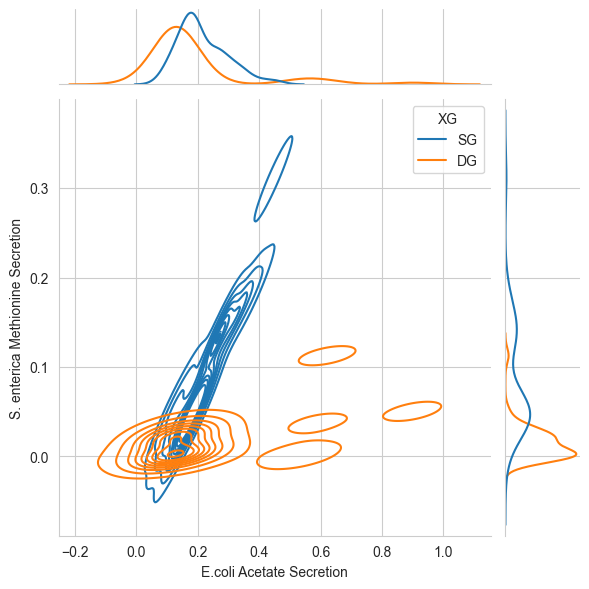

In [ ]:
# cross_m = flux_compare_df.query('XG=="SG"').query("culture=='coculture'")[['EX_bulk_ac_e', 'BIOMASS_iRR1083_metals']]
cross_m = flux_analysis_full.set_index('Species', append=True)[['EX_bulk_ac_e', 'BIOMASS_iRR1083_metals', 'XG']]
# cross_m = cross_m
cross_E = cross_m.query('Species=="E0"')[['EX_bulk_ac_e']].reset_index('Species',drop=True)
cross_S = cross_m.query('Species=="S0"')[['BIOMASS_iRR1083_metals']].reset_index('Species',drop=True)
cf = cross_E.merge(cross_S, left_index=True, right_index=True).dropna()
cf = cf.merge(flux_analysis_full[['XG']], left_index=True, right_index=True, how='left')

# cf.plot.scatter(x='EX_bulk_ac_e', y='BIOMASS_iRR1083_metals', hue='XG')

# sns.scatterplot(cf,x='EX_bulk_ac_e', y='BIOMASS_iRR1083_metals', hue='XG')
sns.jointplot(cf,x='EX_bulk_ac_e', y='BIOMASS_iRR1083_metals', hue='XG', kind='kde')
# plt.title('Cross Feeding Metabolite Production Fluxes')
plt.xlabel('E.coli Acetate Secretion')
plt.ylabel('S. enterica Methionine Secretion')

In [ ]:
colors = {'Synergistic': 'orange', 'Additive': 'purple', 'Antagonistic': 'blue'}
color_list = [colors[group] for group in carbon_allocation_E_wide['categorical_variable']]

# Create a scatter plot with color-coding based on 'categorical_variable'
ax = carbon_allocation_E_wide.plot.scatter('variable1',
                'variable2',
                c=color_list,

In [ ]:
cf.merge(flux_analysis_full[['Drug_comb_effect']], left_index=True, right_index=True)

,EX_bulk_ac_e,BIOMASS_iRR1083_metals,Drug_comb_effect
Gene_inhibition,,,
aroA.argD,0.121148,0.019932,Antagonistic
aroA.argD,0.121148,0.019932,Antagonistic
aroA.dapB,0.164185,0.028739,Antagonistic
aroA.dapB,0.164185,0.028739,Antagonistic
aroA.dapF,0.111557,0.017855,Antagonistic
aroA.dapF,0.111557,0.017855,Antagonistic
aroA.guaB,0.154966,0.028248,Antagonistic
aroA.guaB,0.154966,0.028248,Antagonistic
aroA.pheA,0.126190,0.000025,Synergistic


Index(['EX_lcts_e', 'EX_bulk_ac_e', 'Drug_comb_effect', 'XG'], dtype='object')


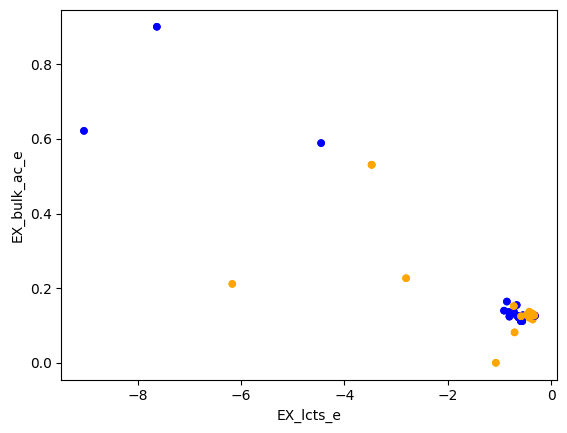

In [ ]:
def plot_flux_ratio(E_col, S_col, XG=['DG'], culture='coculture', Species=['E0', 'S0']):
# cross_m = flux_compare_df.query('XG=="DG"').query("culture=='coculture'")[['EX_bulk_ac_e', 'BIOMASS_iRR1083_metals']]
    if XG is not None:
        cross_m = flux_compare_df
    cross_m = flux_compare_df.query('XG in @XG').query("culture==@culture")
    
    cross_m = cross_m[[E_col, S_col]]
    cross_E = cross_m.query('Species==@Species[0]')[[E_col]].reset_index('Species',drop=True)
    cross_S = cross_m.query('Species==@Species[1]')[[S_col]].reset_index('Species',drop=True)

    # cf = cross_E.merge(cross_S, left_index=True, right_index=True, suffixes=['E','S']).dropna()
    cf = cross_E.merge(cross_S, left_index=True, right_index=True, suffixes=Species).dropna().T.drop_duplicates().T
    cf = cf.merge(flux_analysis_full[['Drug_comb_effect', 'XG']], left_index=True, right_index=True, how='left')
    
    colors = {'Synergistic': 'orange', 'Additive': 'purple', 'Antagonistic': 'blue'}
    color_list = [colors[group] for group in cf['Drug_comb_effect']]

    print(cf.columns)
    if E_col==S_col:
        E_col, S_col = E_col+'E', S_col+'S'
    # return cf
    cf.plot.scatter(x=E_col, y=S_col,c=color_list)
    
    
plot_flux_ratio('EX_lcts_e', 'EX_bulk_ac_e', Species=['E0','E0'])
# cf = plot_flux_ratio('EX_bulk_ac_e', 'EX_bulk_ac_e', XG=['DG'])

In [ ]:
cf

,EX_bulk_ac_eE,EX_bulk_ac_eS,Drug_comb_effect,XG
Gene_inhibition,,,,
aroA.argD,0.121148,-0.378202,Antagonistic,DG
aroA.argD,0.121148,-0.378202,Antagonistic,DG
aroA.dapB,0.164185,-0.503992,Antagonistic,DG
aroA.dapB,0.164185,-0.503992,Antagonistic,DG
aroA.dapF,0.111557,-0.349604,Antagonistic,DG
aroA.dapF,0.111557,-0.349604,Antagonistic,DG
aroA.guaB,0.154966,-0.476150,Antagonistic,DG
aroA.guaB,0.154966,-0.476150,Antagonistic,DG
aroA.pheA,0.126190,-0.136981,Synergistic,DG


<Axes: xlabel='EX_bulk_ac_e', ylabel='BIOMASS_iRR1083_metals'>

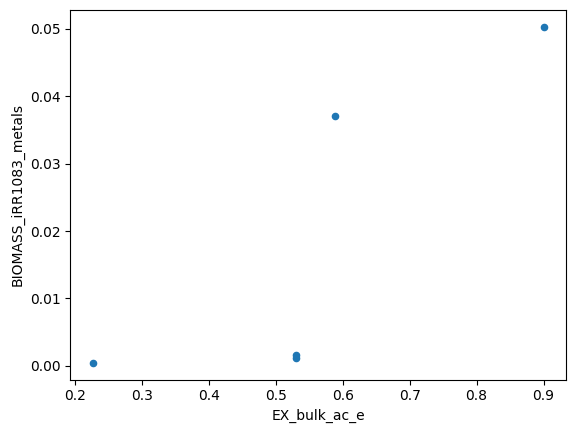

In [ ]:
cf.loc[sr_gc.keys()].plot.scatter(x='EX_bulk_ac_e', y='BIOMASS_iRR1083_metals')

<Axes: xlabel='EX_bulk_ac_e', ylabel='BIOMASS_iRR1083_metals'>

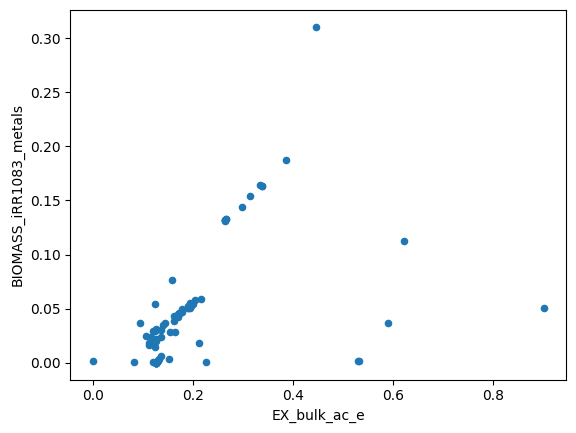